In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Uniaxial_UC.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,...,Si,Mn,P,S,Ni,Cr,Cu,Method,Test Type,Dataset
0,1,400,25400,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
1,1,380,38800,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
2,1,380,48100,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
3,1,370,77200,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
4,1,370,152000,600,825,0.05,0.03,0.0,120,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,400,63000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
202,24,380,165000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
203,24,380,300000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
204,24,360,1030000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4


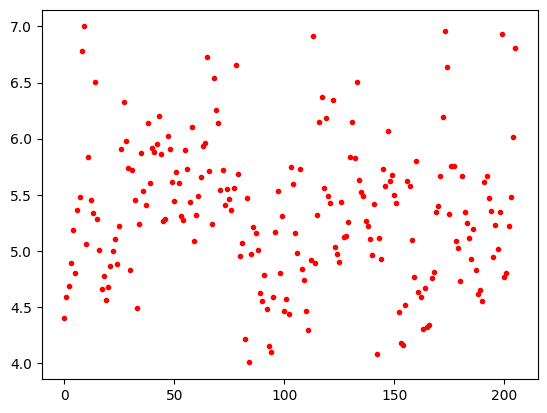

In [ ]:
# Scatter Plot of Target Column
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Dataset','Number of Cycles','Method'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# One-Hot encoding the "Test Type" column
features = pd.get_dummies(features, columns=['Test Type'], prefix='Test Type')

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Heat,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,Test Type_repeated,Test Type_reversed
0,9,490,600,1740,0.07,0.00,0.0,20,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,False,True
1,17,520,600,1750,0.07,0.00,0.0,20,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,False,True
2,10,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,False,True
3,10,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,False,True
4,18,520,600,1270,0.08,0.01,0.0,20,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,340,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,True,False
202,13,350,600,1740,0.07,0.00,0.0,120,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,True,False
203,24,360,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,True,False
204,21,365,600,1750,0.07,0.00,0.0,120,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,True,False


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Custom dataset class for handling features and labels
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 1


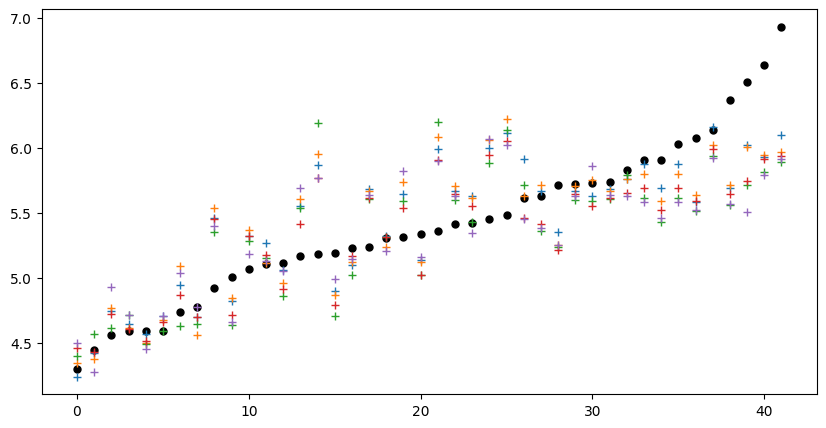

Pearson CC: 0.7717206960236334
R2 score: 0.5911910200931039
RMSE: 0.3844543993473053
MAE: 0.2955487072467804
MAPE: 0.0
Coverage: 42.85714285714286
Upper coverage: 76.19047619047618
Lower coverage: 66.66666666666666
Average Interval Width: 0.3313986361026764
Median Interval Width: 0.2896113395690918
Composite Metric: 1.1846544394901297


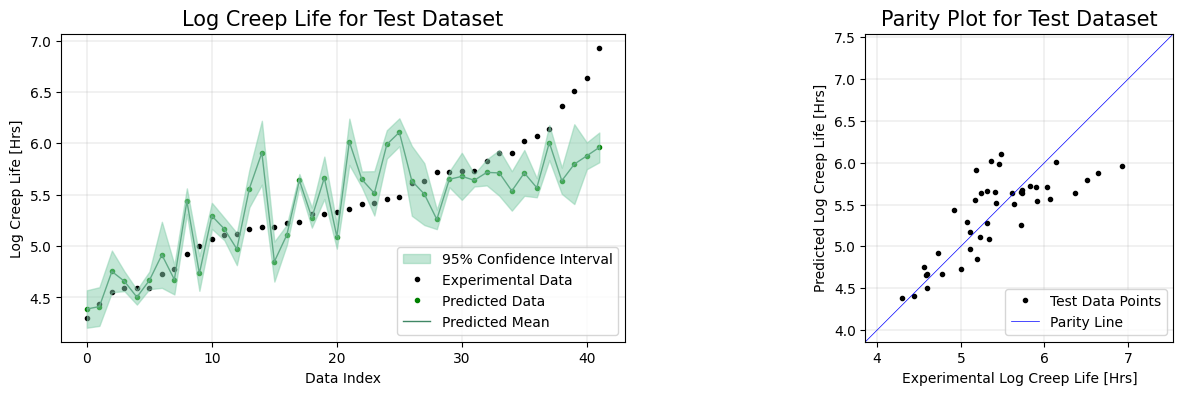

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 2


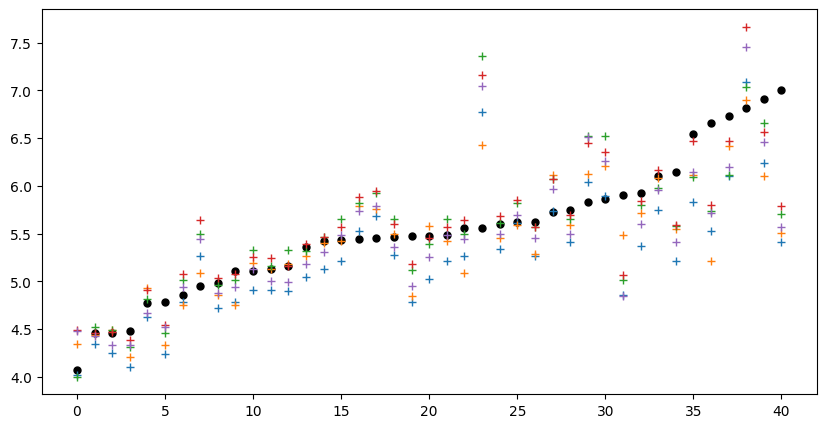

Pearson CC: 0.7760635104099486
R2 score: 0.5489617896683383
RMSE: 0.45971259474754333
MAE: 0.31109845638275146
MAPE: 0.0
Coverage: 63.414634146341456
Upper coverage: 87.8048780487805
Lower coverage: 75.60975609756096
Average Interval Width: 0.6172698140144348
Median Interval Width: 0.5580911636352539
Composite Metric: 0.9235652448954269


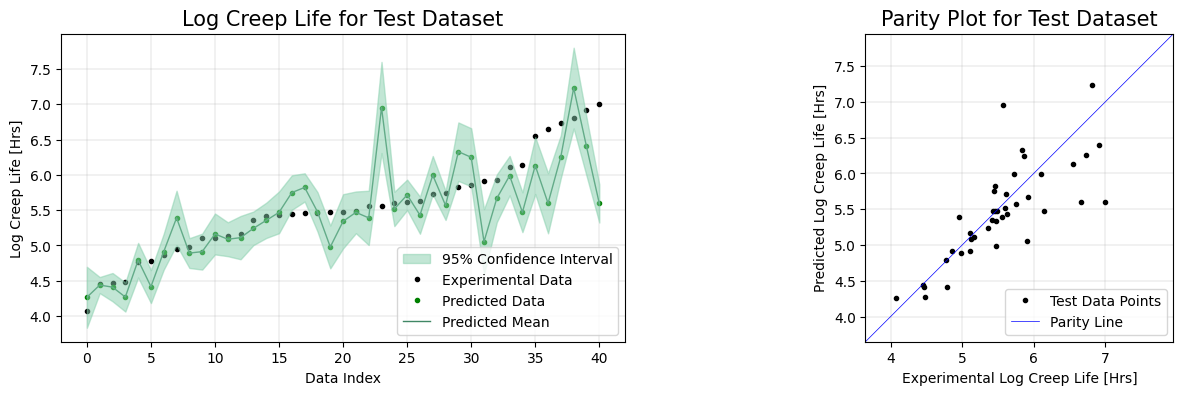

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 3


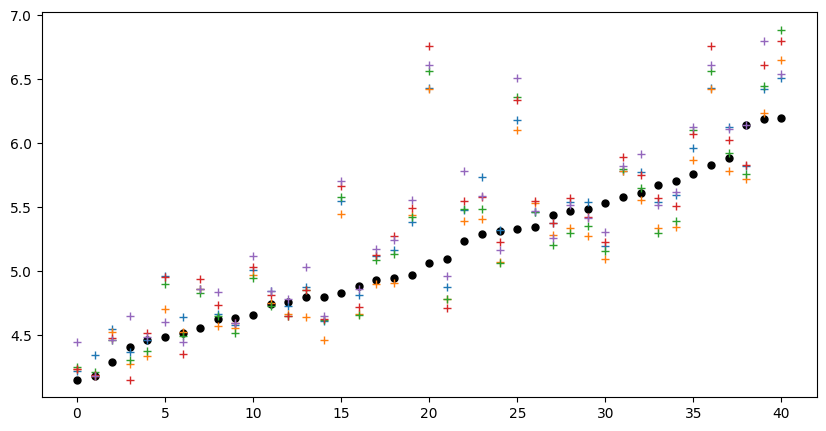

Pearson CC: 0.8450845344416208
R2 score: 0.5104470723347894
RMSE: 0.3874061405658722
MAE: 0.26593881845474243
MAPE: 0.0
Coverage: 53.65853658536585
Upper coverage: 63.41463414634146
Lower coverage: 90.2439024390244
Average Interval Width: 0.38215792179107666
Median Interval Width: 0.36931896209716797
Composite Metric: 1.0793606711434505


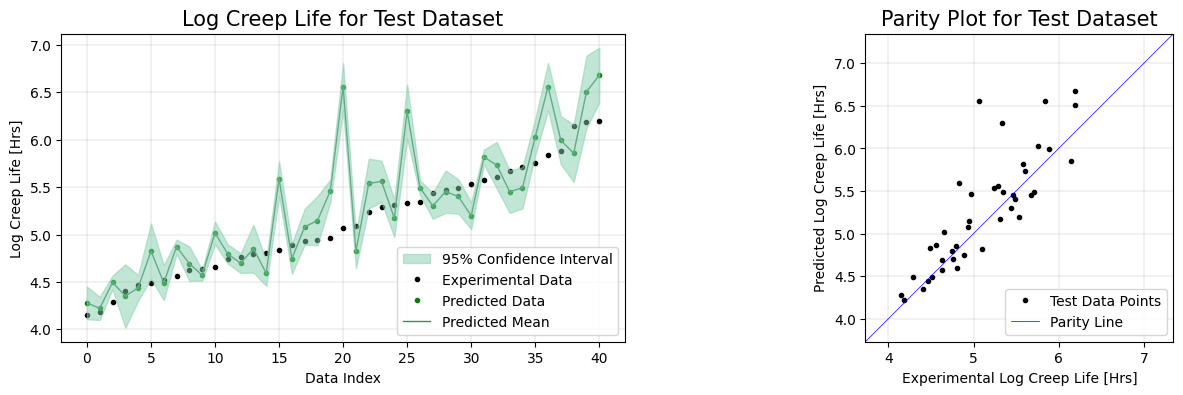

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 4


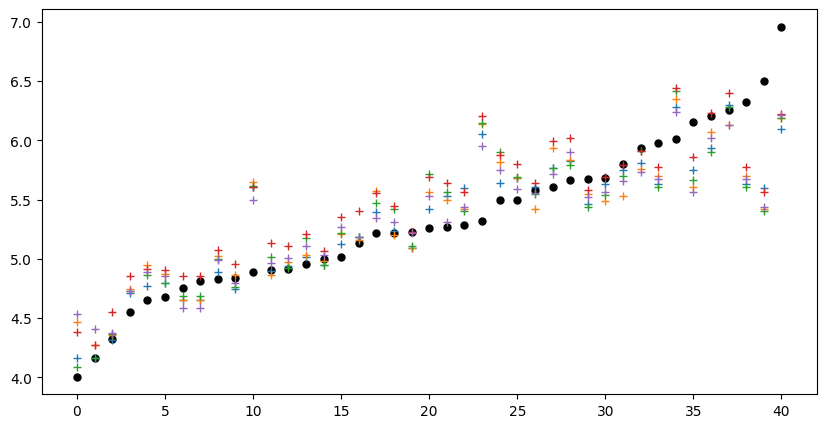

Pearson CC: 0.859566550697979
R2 score: 0.7327473196842091
RMSE: 0.33350905776023865
MAE: 0.24243582785129547
MAPE: 0.0
Coverage: 46.34146341463415
Upper coverage: 60.975609756097555
Lower coverage: 85.3658536585366
Average Interval Width: 0.32428109645843506
Median Interval Width: 0.31829071044921875
Composite Metric: 1.1330064560862776


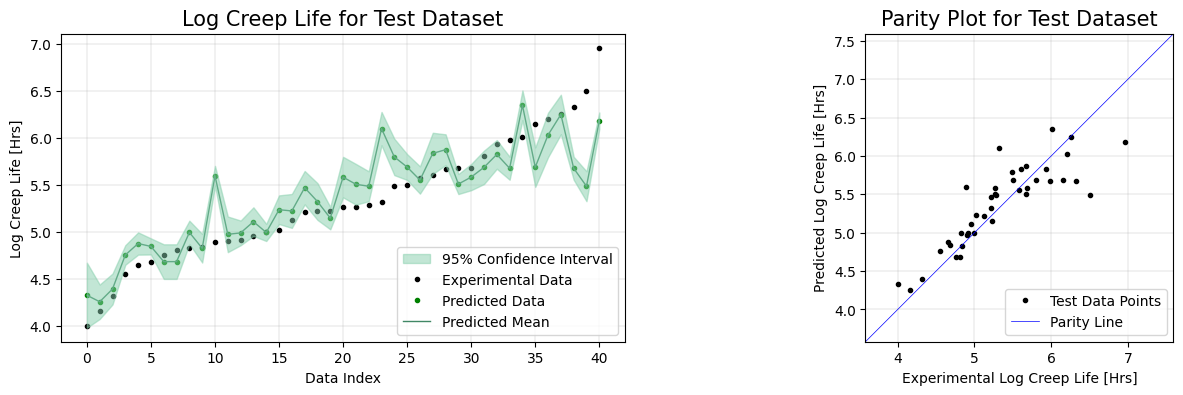

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 5


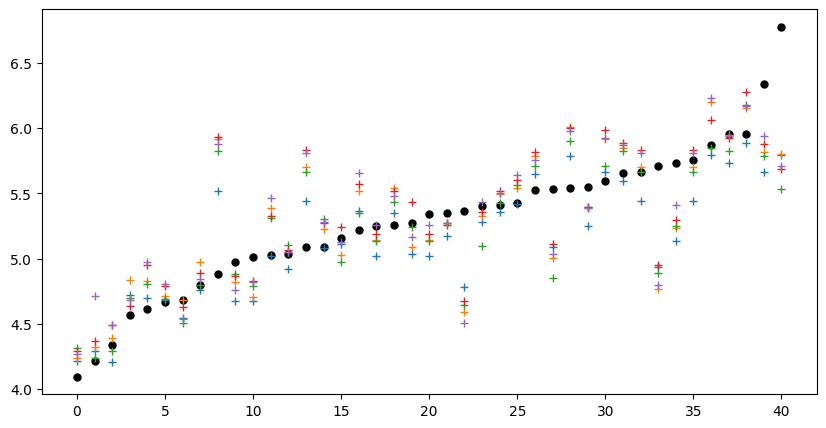

Pearson CC: 0.7583100897962636
R2 score: 0.552246367119591
RMSE: 0.36003172397613525
MAE: 0.25603538751602173
MAPE: 0.0
Coverage: 51.21951219512195
Upper coverage: 78.04878048780486
Lower coverage: 73.17073170731706
Average Interval Width: 0.3799748718738556
Median Interval Width: 0.35102272033691406
Composite Metric: 1.0963509524927186


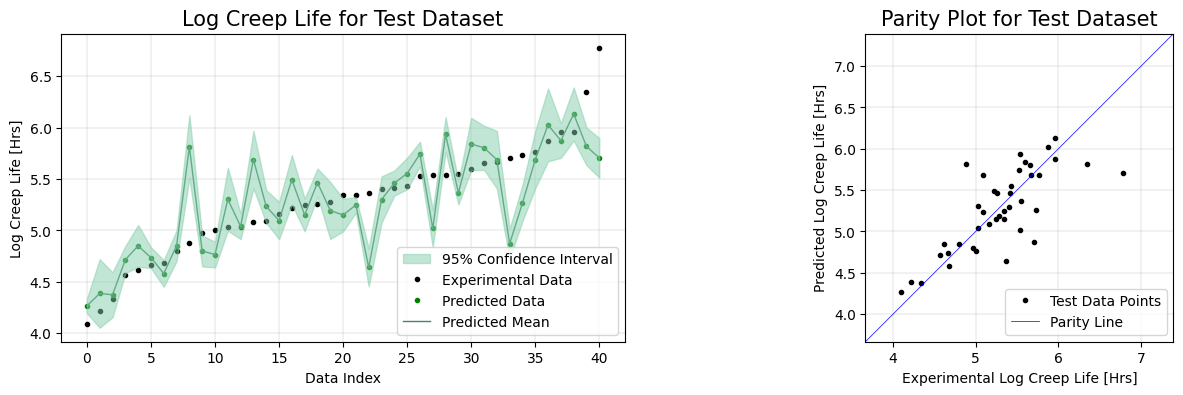

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)


for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=20, output_dim=1, hidden_dim=100, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.5)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            ensemble_size = 5
            ensemble = [MLP(hidden_dim=10, n_hidden_layers=3) for _ in range(ensemble_size)]

            for net in ensemble:
                  train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_preds = [np.array(net(torch.Tensor(x_test)).clone().detach().numpy()) for net in ensemble]
            # mean and standard deviation
            y_pred = np.mean(np.array(y_preds), axis=0)
            y_std = np.std(np.array(y_preds), axis=0)

            # Plot the predictions
            fig, ax = plt.subplots(figsize=(10, 5))
            iteration_list = [ i for i in range(len(y_test))]
            ax.plot(iteration_list, y_test, 'ko', markersize=5)
            for idx in range(len(y_preds)):
                        ax.plot(iteration_list, y_preds[idx], '+')
            plt.legend(loc=4, fontsize=15, frameon=False)
            plt.show()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'MAPE: {MAPE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test_np, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test_np, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test_np, -np.inf, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.771721,0.591191,0.384454,0.295549
1,0.776064,0.548962,0.459713,0.311098
2,0.845085,0.510447,0.387406,0.265939
3,0.859567,0.732747,0.333509,0.242436
4,0.758310,0.552246,0.360032,0.256035


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.802149,0.041638,0.587119,0.077168,0.385023,0.042102,0.274211,0.025395


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,42.857143,76.190476,66.666667,0.331399,0.289611,1.184654
1,63.414634,87.804878,75.609756,0.617270,0.558091,0.923565
2,53.658537,63.414634,90.243902,0.382158,0.369319,1.079361
3,46.341463,60.975610,85.365854,0.324281,0.318291,1.133006
4,51.219512,78.048780,73.170732,0.379975,0.351023,1.096351


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,51.498258,7.042811,73.286876,9.908657,78.211382,8.502059,0.407016,0.107814,0.377267,0.094457,1.083388,0.087686


In [ ]:
experiment_number = 'DeepEnsemble'